In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_addons as tfa
import tensorflow_hub as hub
import cv2

In [2]:
num_classes = 2
input_shape = (100, 100, 3)

pos_dir = "./test_images/"

print(os.path.isdir(pos_dir))
image = image_dataset_from_directory(pos_dir,image_size=(100,100),label_mode='int',batch_size=32)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 16
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of bthe transformer layers
transformer_layers = 4
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier


True
Found 27558 files belonging to 2 classes.


In [3]:
from tqdm import tqdm
x_train = []
y_train = []

for image,y in tqdm(image.as_numpy_iterator()):
    #print("image shape ",image.shape)
    x_train.append(image)
    y_train.append(y)


862it [00:06, 131.52it/s]


In [4]:
X = np.concatenate([*x_train])
y = np.concatenate([*y_train])

In [5]:
X[0].shape

(100, 100, 3)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        self.patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return self.patches
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size
        
        })
        return config 


# split malaria cell image in to patches 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image out (100, 100, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


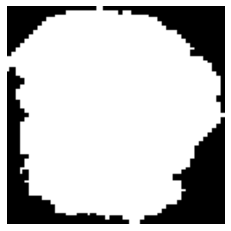

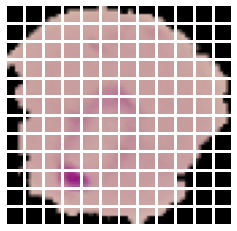

In [9]:
%matplotlib inline

x_train = X[0]

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image_out = x_train

plt.imshow(image_out)
plt.axis("off")
print("image out" ,image_out.shape)

resized_image = tf.image.resize(
    tf.convert_to_tensor([image_out]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



In [10]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.projection_dim = projection_dim

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.encoded = self.projection(patch) + self.position_embedding(positions)
        return self.encoded
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim,
            'projection':self.projection
            
        })
        return config




In [11]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    #patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes,activation='softmax')(features)
    #logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
        
    model = keras.Model(inputs=inputs, outputs=logits)
    
    config = model.get_config()
    
    #custom_objects = {"CustomLayer": CustomLayer, "custom_activation": custom_activation}
    custom_objects = {"Patches": Patches,"PatchEncoder":PatchEncoder}

    with keras.utils.custom_object_scope(custom_objects):
        new_model = keras.Model.from_config(config)
        
        
    return new_model


In [12]:

metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ]


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        #loss= keras.losses.BinaryCrossentropy(),
        #loss= keras.losses.CategoricalCrossentropy()
        loss= keras.losses.SparseCategoricalCrossentropy()
        
    )
    

    history = model.fit(
        X,
        y,
        batch_size=batch_size,
        epochs=num_epochs,
        #callbacks=[checkpoint_callback],
    )


    model.save("vision_transformer_model.h5")
    print("saved")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)



C:\Users\ITSC\anaconda3\envs\vision_transformer\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
862/862 [==============================] - 249s 284ms/step - loss: 0.7382
Epoch 2/100
862/862 [==============================] - 244s 283ms/step - loss: 0.6593
Epoch 3/100
862/862 [==============================] - 244s 283ms/step - loss: 0.6357
Epoch 4/100
862/862 [==============================] - 244s 283ms/step - loss: 0.6180
Epoch 5/100
862/862 [==============================] - 244s 283ms/step - loss: 0.2542
Epoch 6/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1782
Epoch 7/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1680
Epoch 8/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1686
Epoch 9/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1659
Epoch 10/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1658
Epoch 11/100
862/862 [==============================] - 244s 283ms/step - loss: 0.1631
Epoch 12/100
862/862 [==============================

In [13]:
import cv2
import numpy as np


In [14]:
img = cv2.imread("image_1.png")

img = cv2.resize(img,(100,100))
res = img.reshape(1,100,100,3)//255

print(res.shape)

(1, 100, 100, 3)


In [15]:

custom_objects = {"Patches": Patches,"PatchEncoder":PatchEncoder}
loaded_model = keras.models.load_model("vision_transformer_model.h5",custom_objects = custom_objects)

output = loaded_model(res).numpy()
output = np.argmax(output)
print(output)


tf.Tensor([[0.9055281  0.09447187]], shape=(1, 2), dtype=float32)


In [ ]:
if output == 1:
    print(" Infected")
elif output == 0:
    print(" un Infected ")
else:
      pass